In [1]:
import math
import numpy as np
from numba import njit
from matplotlib import pyplot as plt

In [2]:
def ring_sample(c: tuple, r1: float, r2: float, n: int):
    angles = np.random.uniform(0, 2*math.pi, n)
    dists = np.random.uniform(r1, r2, n)
    
    x = c[0] + dists * np.cos(angles)
    y = c[1] + dists * np.sin(angles)
    
    return np.vstack((x, y)).T


def circle_sample(c: tuple, r: float, n: int):
    angles = np.random.uniform(0, 2*math.pi, n)
    dists = np.random.uniform(0, r, n)
    
    x = c[0] + dists * np.cos(angles)
    y = c[1] + dists * np.sin(angles)
    
    return np.vstack((x, y)).T


def circle_dots(c: tuple, r: float, n: int):
    angles = np.linspace(0, 2*math.pi, n)

    x = c[0] + r * np.cos(angles)
    y = c[1] + r * np.sin(angles)

    return np.vstack((x, y)).T


def spiral_sample(c: tuple, da: float, n_loops: int):
    angles = np.arange(0, n_loops * 2 * math.pi, da)
    dists = angles.copy()

    x = c[0] + dists * np.cos(angles)
    y = c[1] + dists * np.sin(angles)

    return np.vstack((x, y)).T

In [3]:
@njit(fastmath=True)
def relu(x: np.ndarray) -> np.ndarray:
    return np.maximum(np.zeros(x.shape), x)


@njit(fastmath=True)
def softmax(x: np.ndarray) -> float:
    y = np.exp(x)
    return y / np.sum(y)


@njit(fastmath=True)
def norm(x: np.ndarray) -> float:
    return math.sqrt(np.sum(np.square(x)))


@njit(fastmath=True)
def norm_squared(x: np.ndarray) -> float:
    return np.sum(np.square(x))


@njit(fastmath=True)
def cosim(a: np.ndarray, b: np.ndarray) -> float:
    return np.dot(a, b) / (norm(a) * norm(b))


@njit(fastmath=True)
def mvcosim(m: np.ndarray, x: np.ndarray) -> np.ndarray:
    x_norm = norm(x)

    n = m.shape[0]
    y = np.zeros(n)
    for i in range(n):
        y[i] = np.dot(m[i], x) / (norm(m[i]) * x_norm)
        
    return y


@njit(fastmath=True)
def gate(x: np.ndarray) -> np.ndarray:
    return np.exp(-np.square(x))

In [4]:
sample1 = circle_sample((0,0), 1, 50)
sample2 = ring_sample((0,0), 5, 5.5, 100)
sample3 = ring_sample((0,0), 10, 10.5, 150)

data = np.vstack((sample1, sample2, sample3))

In [5]:
n1 = 5
n2 = 9
n3 = 16

p1 = circle_dots((0, 0), 0.5, n1)
p2 = circle_dots((0, 0), 5.25, n2)
p3 = circle_dots((0, 0), 10.25, n3)

p = np.vstack((p1, p2, p3))

dist_mtrx = np.zeros((p.shape[0], p.shape[0]))

for i in range(p.shape[0]):
    for j in range(p.shape[0]):
        if i != j:
            dist_mtrx[i][j] = 1 / norm_squared(p[i]-p[j]) / math.sqrt(p.shape[1])

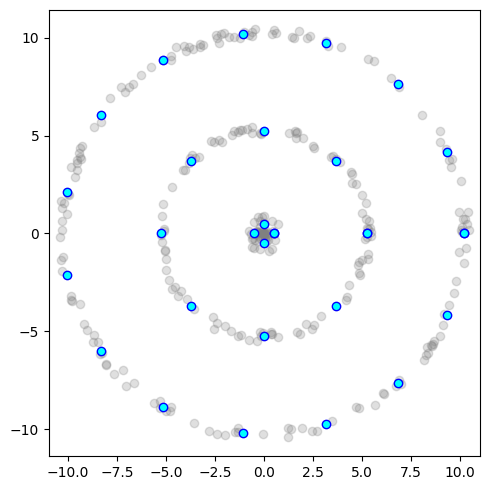

In [6]:
fig = plt.figure(figsize=(5, 5), dpi=100)
ax = fig.add_subplot()

ax.scatter(data[:,0], data[:,1], c='gray', alpha=0.25)
ax.scatter(p[:, 0], p[:, 1], c='cyan', edgecolors='blue')

plt.axis('equal')
plt.tight_layout()
plt.show()

In [29]:
@njit(fastmath=True)
def calc_bound_forces(x: np.ndarray, p: np.ndarray, d: np.ndarray, t: np.ndarray) -> np.ndarray:
    nx = x.shape[0]

    dw: np.ndarray = np.zeros(t.shape)
    dt: np.ndarray = np.zeros(t.shape)

    for i in range(nx):
        # u = p @ x[i]
        u = mvcosim(p, x[i])
        # u = relu(mvcosim(p, x[i]))

        u = np.outer(u, u)

        # q = u
        q = d * u
        r = gate(t) * q

        dw += r
        dt += r

    return (dw, dt)

In [30]:
m = p.shape[0]
w = np.zeros((m, m))
t = np.zeros((m, m))

alpha = 0.1
beta = 0.9

max_epoch = 128
batch_size = 32
learning_rate = 1.0

n = data.shape[0]
n_batches = n // batch_size

for epoch in range(max_epoch):
    idxs = np.random.permutation(n)

    for i in range(n_batches):
        ibegin = i * batch_size
        iend = min((i + 1) * batch_size, n - 1)
        batch_idxs = idxs[ibegin:iend]

        dw, dt = calc_bound_forces(data[batch_idxs], p, dist_mtrx, t)

        w = alpha * w + learning_rate * dw
        t = beta * t + learning_rate * dt

-0.2652443985952796 0.1664603308488184 0.014515513380950248
-2.032522379304481 155.2962458700325 0.6874479890105452


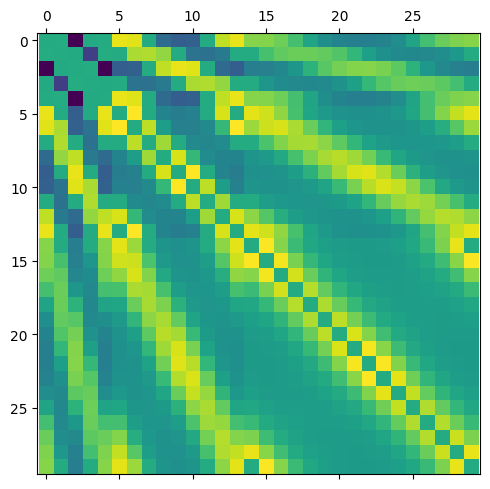

In [31]:
# w = np.clip(w, -2, 2)

print(np.min(w), np.max(w), np.mean(w))
print(np.min(t), np.max(t), np.mean(t))

fig = plt.figure(figsize=(5, 5), dpi=100)
ax = fig.add_subplot()


ax.matshow(w)

plt.axis('equal')
plt.tight_layout()
plt.show()

In [10]:
from matplotlib.cm import binary, RdBu_r, RdYlBu_r, bwr

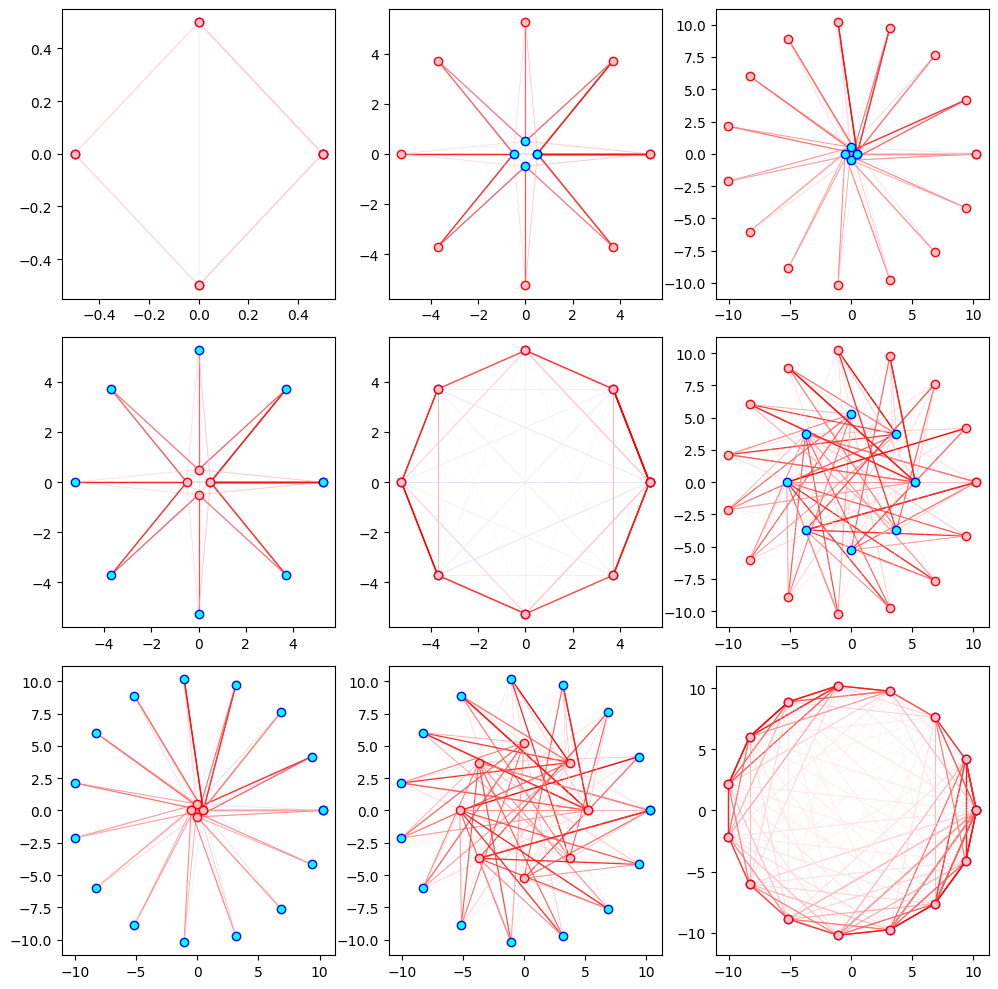

In [32]:
fig, axes = plt.subplots(nrows=3, ncols=3)
fig.set_dpi(100)
fig.set_figwidth(10)
fig.set_figheight(10)

v = (w - np.min(w)) / (np.max(w) - np.min(w))
# vv = -1 + 2*(w - np.min(w)) / (np.max(w) - np.min(w))

pts = [p1, p2, p3]

idxs = [
    list(range(0, n1)),
    list(range(n1, n1+n2)),
    list(range(n2, n2+n3)),
]

for i in range(3):
    for j in range(3):
        for ii, pi in enumerate(pts[i]):
            for jj, pj in enumerate(pts[j]):
                x = [pi[0], pj[0]]
                y = [pi[1], pj[1]]

                idxi = idxs[i][ii]
                idxj = idxs[j][jj]

                c = bwr(v[idxi][idxj])

                axes[i][j].plot(x, y, c=c, alpha=v[idxi][idxj], lw=v[idxi][idxj])

        axes[i][j].scatter(pts[i][:, 0], pts[i][:, 1], c='cyan', edgecolors='blue', zorder=2)
        axes[i][j].scatter(pts[j][:, 0], pts[j][:, 1], c='pink', edgecolors='red', zorder=2)

plt.axis('equal')
plt.tight_layout()
plt.show()